In [7]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [12]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [13]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [14]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

Statsmodels sandwich variance estimators
https://github.com/statsmodels/statsmodels/blob/master/statsmodels/stats/sandwich_covariance.py

## 1. Experiments with no covariates in the DGP

$y_i = \tau*T_i+e_i$

In [24]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:02<00:00, 181.00it/s]


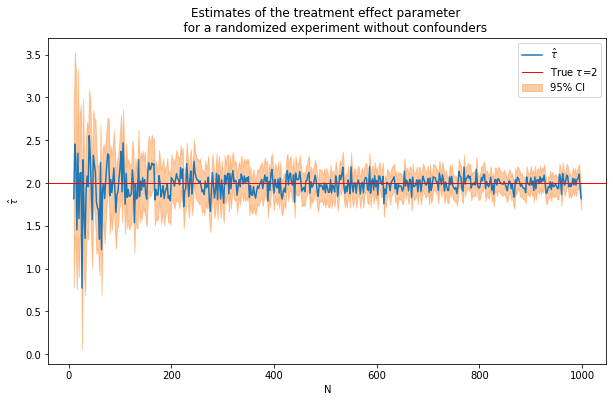

In [25]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

##### For selected N check that this is the same as running a regression with a intercept

In [18]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [19]:
tauhat,se_tauhat

(1.7194131060756241, 0.1893088683205976)

In [20]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])

In [21]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(1.7194131060756237, 0.1893088683205976)

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [26]:
estDict = {}
R = 2000
for N in [10,50,100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:27<00:00, 74.00it/s] 


In [28]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    


N=10: bias=-0.014638567909864545, RMSE=0.6394512864727265, size=0.0885
N=50: bias=-0.0049579172696585004, RMSE=0.28842551549352036, size=0.0655
N=100: bias=-0.010521803984972442, RMSE=0.20079812295951735, size=0.0525
N=500: bias=-0.0004475702945030123, RMSE=0.08847220007778381, size=0.0515
N=1000: bias=-0.00037883157937414934, RMSE=0.0631359339080983, size=0.0485


## 1. Experiments with covariates in the DGP

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [29]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:10<00:00, 48.54it/s] 


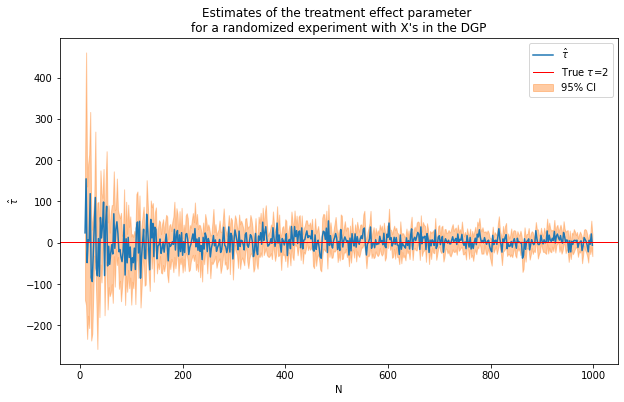

In [30]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [34]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:09<00:00, 51.30it/s] 


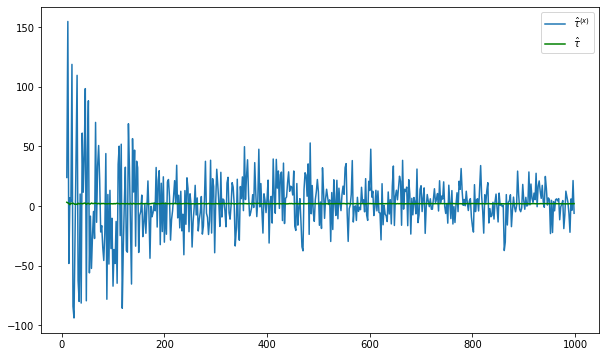

In [35]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

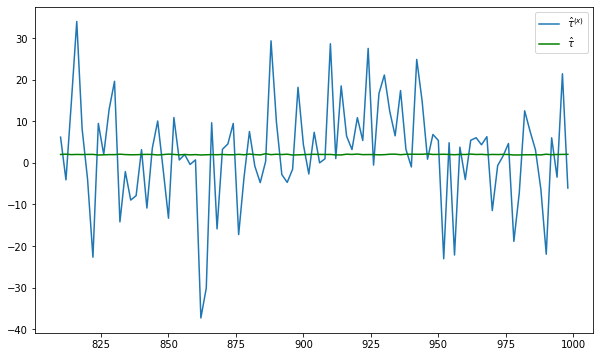

In [36]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

Repeat experiment with larger N

In [37]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(1000,50000,10000) # loop over N values
(nvalues_x2,tauhats_x2,sehats_x2,lb_x2,ub_x2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 5/5 [00:44<00:00,  8.99s/it]


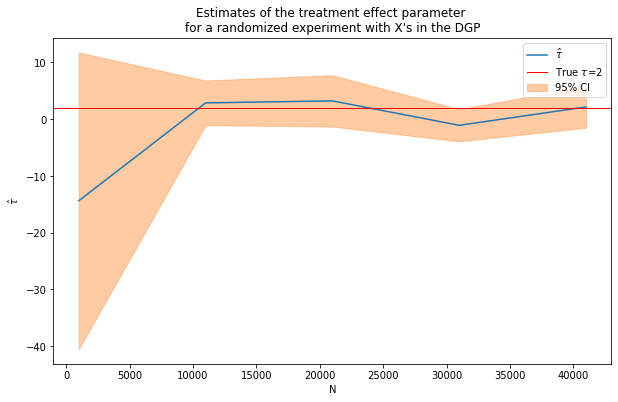

In [38]:
fn_plot_with_ci(nvalues_x2,tauhats_x2,tau,lb_x2,ub_x2,caption)

Still pretty noisy!

## DGP with X - adding covariates to the regression
Use same DGP as before

In [39]:
# Use same DGP as
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|██████████| 450/450 [00:10<00:00, 44.17it/s]


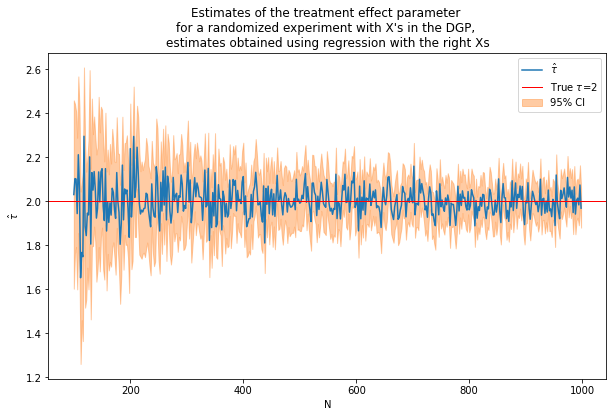

In [40]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

Including X's improves precision. However, we cheated because we included the right X's from the start! 

What happens if we use some X's that influence the outcome and some that don't?

In [41]:
# Use same DGP as
tau = 2
corr = .5
conf=False
p = 1000
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 2
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|██████████| 450/450 [01:20<00:00,  5.61it/s]


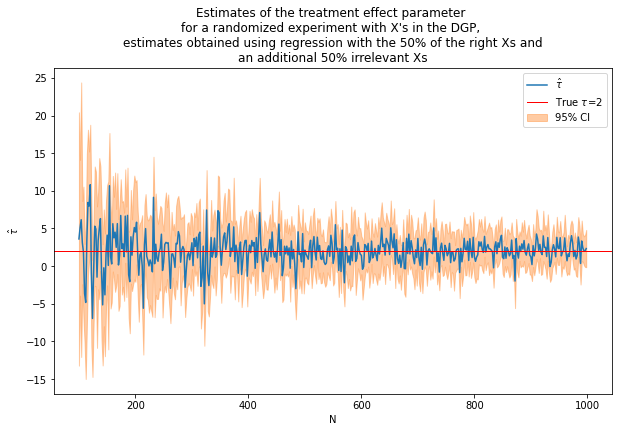

In [42]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the 50% of the right Xs and
an additional 50% irrelevant Xs"""
fn_plot_with_ci(nvalues3,tauhats3,tau,lb3,ub3,caption)

### <font color='red'> What do we do when we have a lot of covariates and we don't know which/if any are relevant? Or when treatment effects are heterogenous? </font>

# AB testing

How does seasonality affect AB testing?

In [120]:
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Yab, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive

/Users/manguito/.virtualenvs/myEnv/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [125]:
lassoreg = Lasso(alpha=1.0,normalize=True, max_iter=1e5)
res = lassoreg.fit(X,Yab)

In [129]:
res.

100000.0

In [ ]:
lasso.fit.outcome <- cv.glmnet(data.matrix(X), df$Y.ab, alpha=1)
coef <- predict(lasso.fit.outcome, type = "nonzero")
H <- X.colnames[unlist(coef)]

lasso.fit.propensity <- cv.glmnet(data.matrix(X), df$T, alpha=1)
coef <- predict(lasso.fit.propensity, type = "nonzero")
K <- X.colnames[unlist(coef)]

# Union of selected variables:
H_union_K.names <- unique(c(H, K))
H_union_K.names
sum.H_union_K <- paste(H_union_K.names, collapse = " + ")
eq.H_union_K <- paste("Y.ab ~ T + ", sum.H_union_K)

# OLS regression, using all covariates selected by double selection
fit.double <- lm(eq.H_union_K, data = df)
T.double <- fit.double$coefficients[2]
ci.double <- confint(fit.double, 'T', level = 0.95)


# Alternate methods:
#    OLS of Y on T
fit.simple <- lm('Y.ab ~ T', data = df)
#summary(fit.simple)
T.simple <- fit.simple$coefficients[2]
ci.simple <- confint(fit.simple, 'T', level = 0.95)

#    OLS of Y on T,controlling for all of X
sum.X <- paste(X.colnames, collapse = " + ")
eq.control.all <- paste("Y.ab ~ T + ", sum.X)
fit.allX <- lm(eq.control.all, data = df)
#summary(fit.allX)
T.allX <- fit.allX$coefficients[2]
ci.allX <- confint(fit.allX, 'T', level = 0.95)

#    OLS of Y on T,controlling for (almost) all of X
sum.Xmost <- paste(X.colnames[0:(N-10)], collapse = " + ")
eq.control.almost <- paste("Y.ab ~ T + ", sum.Xmost)
fit.mostX <- lm(eq.control.almost, data = df)
#summary(fit.allX)
T.mostX <- fit.mostX$coefficients[2]
ci.mostX <- confint(fit.mostX, 'T', level = 0.95)

#    OLS of Y on T, with a subset of X
sum.X.subset <- paste(c(X.colnames[5:15], X.colnames[80:90]), collapse = " + ")
eq.control.subset <- paste("Y.ab ~ T + ", sum.X.subset)
fit.subsetX <- lm(eq.control.subset, data = df)
#summary(fit.subsetX)
T.subsetX <- fit.subsetX$coefficients[2]
ci.subsetX <- confint(fit.subsetX, 'T', level = 0.95)

# Vector of T coefficients and confidence intervals
coefs.ab <- c(2.0, T.simple, T.allX, T.mostX, T.subsetX, T.double)
ci.low <- c(NaN, ci.simple[1], ci.allX[1], ci.mostX[1], ci.subsetX[1], ci.double[1])
ci.high <- c(NaN, ci.simple[2], ci.allX[2], ci.mostX[2], ci.subsetX[2], ci.double[2])
dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'No Controls', 'All X', 'Largest Subset of X', 'Limited Controls', 'Double Selection'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)
dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

# Create bar graph
dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)
p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))
p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on Treatment") +
    ggtitle("Estimated Causal Effect of T on Y, for various models") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

In [ ]:
colnames(simulated.data)[1] <- 'W' # Running variable for RDD
colnames(simulated.data)[total.covar] <- 'C' # Unobservable variable
# Random assignment for A/B test
T <- rep(0, N)
T[0:(N/2)] <- 1
T <- sample(T)
X <- simulated.data[, 2:(total.covar-1)]
covariate.names <- colnames(X)
# Independent error terms
error <- rnorm(n = N)
# Make W a function of the X's and unobservable (for RDD)
simulated.data$W <- simulated.data$W + .5 * simulated.data$C + 3 * simulated.data$V80 - 6 * simulated.data$V81
# Assign treatment, based on a threshold along W
treated <- (simulated.data$W > 0) * 1.0
# True coefficients on controls
beta.true.linear <- rnorm(p, mean = 5, sd = 5)
beta.true.linear[30:p] <- 0
# Functional form of Y for A/B test:
Y.ab <- 2.0 * T + data.matrix(X) %*% beta.true.linear + .6 * simulated.data$C + error
# Functional form of Y for RDD (function of treatment, W, X's, and unobservable C)
Y.rdd <- 1.2 * treated - 4 * simulated.data$W  + data.matrix(X) %*% beta.true.linear + .6 * simulated.data$C + error
df <- cbind(Y.ab, Y.rdd, T, simulated.data)
colnames(df)[1:3] <- c('Y.ab', 'Y.rdd', 'T')
X.colnames <- colnames(X)

In [48]:
X[:,0]==allX[:,2]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,